# classfication

# 准备数据

In [62]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

# 加载Fashion MNIST数据集，张量就是和numpy数组一样
transform = transforms.Compose([transforms.ToTensor()])#ToTensor将数据转换为张量，并归一化到0-1之间
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
train_dataset[0]
train_dataset[0][0].shape #1*28*28的ndarray

torch.Size([1, 28, 28])

In [63]:
type(train_dataset)

torchvision.datasets.mnist.FashionMNIST

In [64]:
# 获取图像和标签
train_images = train_dataset.data.numpy() 
train_labels = train_dataset.targets.numpy()
test_images = test_dataset.data.numpy()
test_labels = test_dataset.targets.numpy()

# 定义类别名称
class_names = ['T-shirt/top', '裤子', '套头衫', '连衣裙', '外套',
               '凉鞋', '衬衫', '运动鞋', '包', '短靴']

# 查看数据集基本信息
print(f"训练集形状: {train_images.shape}")
print(f"训练集标签数量: {len(train_labels)}")
print(f"测试集形状: {test_images.shape}")
print(f"测试集标签数量: {len(test_labels)}")
train_images[0] #28*28的ndarray

train_labels[0:5]

训练集形状: (60000, 28, 28)
训练集标签数量: 60000
测试集形状: (10000, 28, 28)
测试集标签数量: 10000


array([9, 0, 0, 3, 0], dtype=int64)

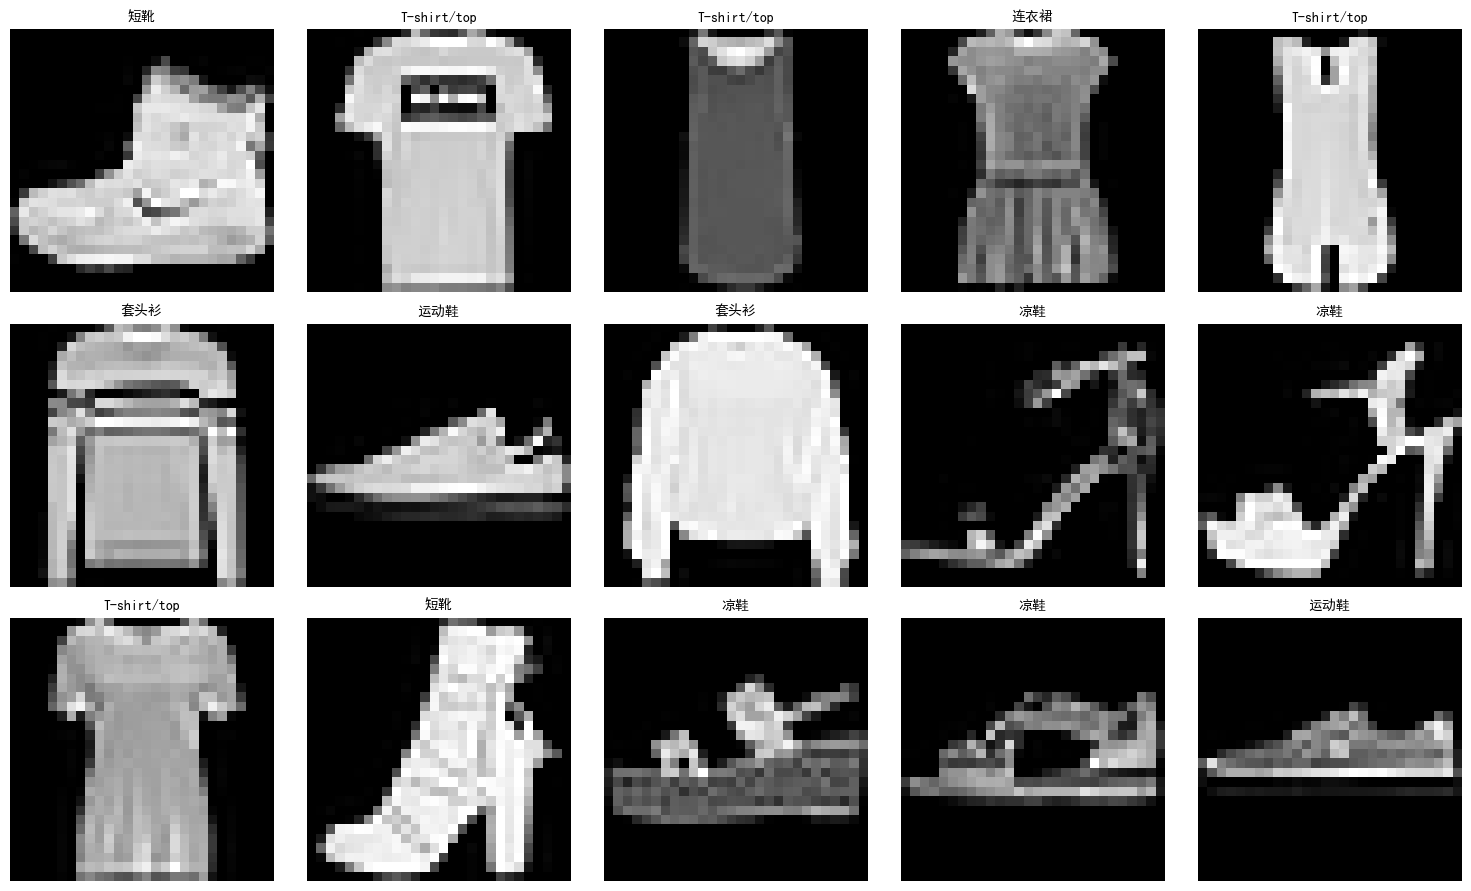

In [65]:
# 导入matplotlib用于绘图
import matplotlib.pyplot as plt
import matplotlib

# 设置中文字体，解决中文显示问题
matplotlib.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体
matplotlib.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 创建一个3行5列的图表来显示前15个样本
plt.figure(figsize=(15, 9))  # 设置图表大小

# 遍历前15个样本
for i in range(15):
    # 创建子图
    plt.subplot(3, 5, i + 1)
    
    # 显示图像
    plt.imshow(train_images[i], cmap='gray')
    
    # 添加标题（显示类别名称）
    plt.title(class_names[train_labels[i]], fontsize=10)
    
    # 关闭坐标轴
    plt.axis('off')

# 调整子图之间的间距
plt.tight_layout()

# 显示图表
plt.show()

# 数据集划分训练，验证以及设置3个加载器

In [66]:
# 设置随机种子以确保结果可复现
torch.manual_seed(42)

# 定义设备（GPU/CPU）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 划分数据集为训练集和验证集
train_size = 55000
val_size = 5000

# 使用torch.utils.data.random_split函数接口划分数据集
train_subset, val_subset = torch.utils.data.random_split(
    train_dataset, 
    [train_size, val_size]
)

print(f"训练集大小: {train_size}")
print(f"验证集大小: {val_size}")

# 创建数据加载器
batch_size = 64  # 批次大小

# torch.utils.data.DataLoader是PyTorch提供的一个数据加载器，用于将数据集划分为多个批次，并进行随机打乱和并行加载

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,  # 打乱数据
    num_workers=2,  # 多进程加载数据
    pin_memory=True  # 将数据加载到CUDA固定内存中，加速GPU训练
)

# 验证数据加载器
val_loader = torch.utils.data.DataLoader(
    val_subset,
    batch_size=batch_size,
    shuffle=False,  # 验证集不需要打乱
    num_workers=2,
    pin_memory=True
)
# 测试数据加载器
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)



训练集大小: 55000
验证集大小: 5000


# 定义并搭建模型

In [67]:
import torch.nn as nn
import torch.nn.functional as F

# 检查CUDA是否可用，如果可用则使用GPU，否则使用CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

class NeuralNetwork(nn.Module):
    # 定义神经网络的结构
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            # 输入层 -> 第一隐藏层 (28*28=784 -> 300)
            nn.Linear(28 * 28, 300),  # in_features=784, out_features=300
            nn.ReLU(),
            # 第一隐藏层 -> 第二隐藏层 (300 -> 100)
            nn.Linear(300, 100),
            nn.ReLU(),
            # 第二隐藏层 -> 输出层 (100 -> 10，对应10个数字类别)
            nn.Linear(100, 10),
        )

    def forward(self, x):
        # x.shape [batch size, 1, 28, 28]
        x = self.flatten(x)  
        # 展平后 x.shape [batch size, 28 * 28]
        logits = self.linear_relu_stack(x)
        # logits.shape [batch size, 10],等价与x = self.fc3(x)
        return logits

# 创建神经网络实列化模型
model = NeuralNetwork()
# 将模型移动到指定设备上
model = model.to(device)

# 从train_loader获取第一个批次的数据，dataiter是迭代器，images和labels是批次数据
dataiter = iter(train_loader)
images, labels = next(dataiter)

# 查看批次数据的形状
print("批次图像形状:", images.shape)
print("批次标签形状:", labels.shape)

# 选择第一张图像进行前向传播测试,unsqueeze(0)是添加批次维度
test_image = images[0].unsqueeze(0).to(device)  # 添加批次维度并移动到设备上
print("测试图像形状:", test_image.shape)

print('-'*100)
# 进行前向传播
with torch.no_grad():  # 不需要计算梯度
    outputs = model(test_image)

# 获取预测结果
_, predicted = torch.max(outputs, 1)
print("模型预测结果:", predicted.item())
print("实际标签:", labels[0].item())

使用设备: cpu
批次图像形状: torch.Size([64, 1, 28, 28])
批次标签形状: torch.Size([64])
测试图像形状: torch.Size([1, 1, 28, 28])
----------------------------------------------------------------------------------------------------
模型预测结果: 2
实际标签: 7


# 计算参数量

In [68]:
# 计算模型的总参数量
total_params = sum(p.numel() for p in model.parameters())
print(f"模型总参数量: {total_params}")

# 查看每层参数量明细
print("\n各层参数量明细:")
for name, param in model.named_parameters():
    print(f"{name}: {param.numel()} 参数")

模型总参数量: 266610

各层参数量明细:
linear_relu_stack.0.weight: 235200 参数
linear_relu_stack.0.bias: 300 参数
linear_relu_stack.2.weight: 30000 参数
linear_relu_stack.2.bias: 100 参数
linear_relu_stack.4.weight: 1000 参数
linear_relu_stack.4.bias: 10 参数


# 分类设置交叉熵损失函数，SGD优化器

In [69]:
# 设置优化器 - SGD（随机梯度下降）
# 参数:
# - model.parameters(): 需要优化的参数
# - lr: 学习率，控制每次参数更新的步长
# - momentum: 动量因子，帮助加速收敛并减少震荡
# - weight_decay: L2正则化系数，防止过拟合
model = NeuralNetwork()
# 定义损失函数和优化器
loss_fn = nn.CrossEntropyLoss()  # 交叉熵损失函数，适用于多分类问题，里边会做softmax，还有会把0-9标签转换成one-hot编码
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)  # SGD优化器，学习率为0.01，动量为0.9

print("损失函数:", loss_fn)
print("优化器:", optimizer)


损失函数: CrossEntropyLoss()
优化器: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)


# 编写评估函数

In [70]:
# # 编写评估函数
# 用于评估模型在测试集上的性能

def evaluate(model, test_loader, loss_fn, device="cpu"):
    """
    评估函数，用于评估模型在测试集上的性能
    
    参数:
    - model: 神经网络模型
    - test_loader: 测试数据加载器
    - loss_fn: 损失函数
    - device: 计算设备，默认为CPU
    
    返回:
    - test_loss: 测试集上的平均损失
    - accuracy: 测试集上的准确率
    """
    # 将模型设置为评估模式
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    
    # 使用torch.no_grad()避免在评估时计算梯度
    with torch.no_grad():
        for data, target in test_loader:
            # 将数据移动到指定设备
            data, target = data.to(device), target.to(device)
            
            # 前向传播
            output = model(data)
            
            # 计算损失
            loss = loss_fn(output, target)
            test_loss += loss.item()
            
            # 获取预测结果
            _, predicted = output.max(1)
            
            # 统计正确预测的数量
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
    
    # 计算平均损失和准确率
    test_loss /= len(test_loader)
    accuracy = 100. * correct / total
    
    print(f'测试集上的损失: {test_loss:.4f}, 准确率: {accuracy:.2f}%')
    return test_loss, accuracy


# 训练函数

In [73]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=5):
    """
    训练模型函数
    
    参数:
        model: 要训练的模型
        train_loader: 训练数据加载器
        val_loader: 验证数据加载器
        criterion: 损失函数
        optimizer: 优化器
        device: 计算设备(CPU/GPU)
        num_epochs: 训练轮数
        
    返回:
        model: 训练好的模型
        history: 训练历史数据，包含每轮的损失和准确率
    """
    # 记录训练历史
    history = {
        'train_loss': [], # 存储每轮训练损失
        'train_acc': [],  # 存储每轮训练准确率
        'val_loss': [],   # 存储每轮验证损失
        'val_acc': []     # 存储每轮验证准确率
    }
    
    # 训练循环，迭代指定的轮数
    for epoch in range(num_epochs):
        model.train()  # 设置模型为训练模式，启用dropout和batch normalization
        running_loss = 0.0 # 当前轮次的累计训练损失
        correct = 0 # 当前轮次训练集上的正确预测数
        total = 0   # 当前轮次训练集的样本总数
        
        # 训练一个epoch,把55000全部训练一遍
        for i, (images, labels) in enumerate(train_loader):
            # 将数据移动到指定设备(GPU/CPU)
            images, labels = images.to(device), labels.to(device)
            
            # 每次迭代前梯度清零，防止梯度累积
            optimizer.zero_grad()
            
            # 前向传播：通过模型获取预测结果
            outputs = model(images)
            # 计算损失：预测值与真实值之间的差异
            loss = criterion(outputs, labels)
            
            # 反向传播与优化
            loss.backward() # 反向传播，计算每个参数的梯度
            optimizer.step() # 优化器根据梯度更新模型参数
            
            # 统计训练集损失和准确率
            running_loss += loss.item() # 累加批次损失
            _, predicted = torch.max(outputs.data, 1) # torch.max(outputs.data, 1)返回两个值，第一个是最大值，第二个是最大值的索引
            total += labels.size(0) # 累加样本数量
            correct += (predicted == labels).sum().item() # 累加正确预测数量
            
            # 每100个批次打印一次进度信息
            if (i + 1) % 100 == 0:
                print(f'轮次 [{epoch+1}/{num_epochs}], 批次 [{i+1}/{len(train_loader)}], 损失: {loss.item():.4f}', end='\r')
        
        # 计算当前epoch的平均损失和准确率
        epoch_train_loss = running_loss / len(train_loader) # 平均损失
        epoch_train_acc = 100 * correct / total # 准确率百分比
        
        # 使用evaluate_model函数评估验证集性能
        val_acc, val_loss = evaluate_model(model, val_loader, device, criterion)
        
        # 记录本轮训练和验证的历史数据
        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # 打印当前轮次的完整训练信息，每轮会迭代只会打印一次
        print(f'轮次 {epoch+1}/{num_epochs} 完成! 训练损失: {epoch_train_loss:.4f}, 训练准确率: {epoch_train_acc:.2f}%, 验证损失: {val_loss:.4f}, 验证准确率: {val_acc:.2f}%')
    
    # 返回训练好的模型和训练历史
    return model, history


In [58]:
# 要先运行下面的代码后才能重新定义模型，需要编写模型结构
model = NeuralNetwork()

# 设置优化器 - SGD（随机梯度下降）
# 参数:
# - model.parameters(): 需要优化的参数
# - lr: 学习率，控制每次参数更新的步长
# - momentum: 动量因子，帮助加速收敛并减少震荡
# - weight_decay: L2正则化系数，防止过拟合
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

# 1. 搭建模型并实列化对象
# 2 .定义损失函数 采用交叉熵损失函数并定义优化器 采用SGD
# 3. 编写评估函数
# 4. 编写训练函数



In [74]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

model, history = train_model(model, train_loader, val_loader, loss_fn, optimizer, device, num_epochs=20)


使用设备: cpu
轮次 1/20 完成! 训练损失: 0.2937, 训练准确率: 89.04%, 验证损失: 0.2957, 验证准确率: 88.54%
轮次 2/20 完成! 训练损失: 0.2835, 训练准确率: 89.44%, 验证损失: 0.2940, 验证准确率: 89.02%
轮次 3/20 完成! 训练损失: 0.2727, 训练准确率: 89.82%, 验证损失: 0.2545, 验证准确率: 90.42%
轮次 4/20 完成! 训练损失: 0.2617, 训练准确率: 90.28%, 验证损失: 0.2597, 验证准确率: 90.14%
轮次 5/20 完成! 训练损失: 0.2549, 训练准确率: 90.50%, 验证损失: 0.2647, 验证准确率: 89.84%
轮次 6/20 完成! 训练损失: 0.2461, 训练准确率: 90.83%, 验证损失: 0.2539, 验证准确率: 90.68%
轮次 7/20 完成! 训练损失: 0.2390, 训练准确率: 91.06%, 验证损失: 0.2525, 验证准确率: 90.16%
轮次 8/20 完成! 训练损失: 0.2321, 训练准确率: 91.37%, 验证损失: 0.2622, 验证准确率: 89.80%
轮次 9/20 完成! 训练损失: 0.2256, 训练准确率: 91.58%, 验证损失: 0.2229, 验证准确率: 91.62%
轮次 10/20 完成! 训练损失: 0.2180, 训练准确率: 91.84%, 验证损失: 0.2267, 验证准确率: 91.58%
轮次 11/20 完成! 训练损失: 0.2129, 训练准确率: 92.05%, 验证损失: 0.2354, 验证准确率: 91.34%
轮次 12/20 完成! 训练损失: 0.2081, 训练准确率: 92.23%, 验证损失: 0.2139, 验证准确率: 91.26%
轮次 13/20 完成! 训练损失: 0.2019, 训练准确率: 92.46%, 验证损失: 0.2084, 验证准确率: 92.26%
轮次 14/20 完成! 训练损失: 0.1969, 训练准确率: 92.63%, 验证损失: 0.2046, 验证准确率: 92.38%
轮次 15/20 完成! 训练损失: 

In [28]:
# 1. tensorboard 可视化
# tensorboard_callback = TensorBoardCallback("runs")
# tensorboard_callback.draw_model(model, [1, 28, 28]) #画模型结构图
# 2. save best
# save_ckpt_callback = SaveCheckpointsCallback("checkpoints", save_best_only=True)
# 3. early stop
# early_stop_callback = EarlyStopCallback(patience=5)

# 绘制损失曲线和准确率曲线

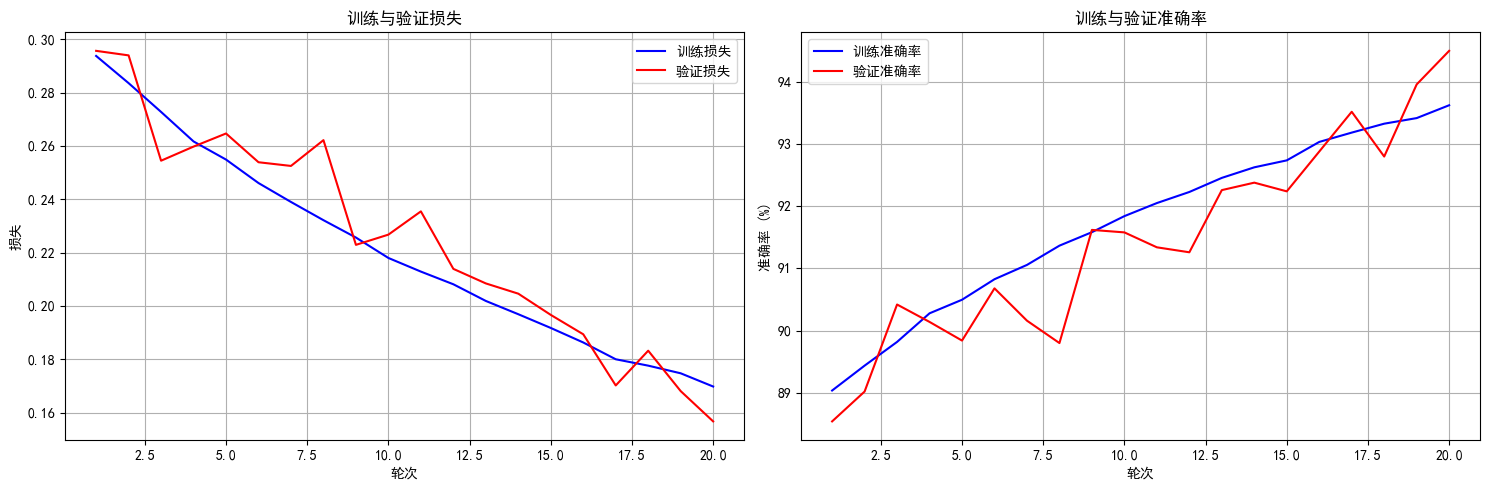

In [81]:
# 导入绘图库
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import font_manager

# 设置中文字体支持
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体
plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示问题

# 创建一个图形，包含两个子图（损失和准确率）
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# 绘制损失曲线
epochs = range(1, len(history['train_loss']) + 1)
ax1.plot(epochs, history['train_loss'], 'b-', label='训练损失')
ax1.plot(epochs, history['val_loss'], 'r-', label='验证损失')
ax1.set_title('训练与验证损失')
ax1.set_xlabel('轮次')
ax1.set_ylabel('损失')
ax1.legend()
ax1.grid(True)

# 绘制准确率曲线
ax2.plot(epochs, history['train_acc'], 'b-', label='训练准确率')
ax2.plot(epochs, history['val_acc'], 'r-', label='验证准确率')
ax2.set_title('训练与验证准确率')
ax2.set_xlabel('轮次')
ax2.set_ylabel('准确率 (%)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


In [77]:
# 在测试集上评估模型
test_accuracy = evaluate_model(model, test_loader, device)
test_accuracy

89.55